Vdc: 50.0000 V
Vref max: 28.8675 V
sampling period: 142.8571 us
dt: 1.1429 us


Text(0.5, 0, 'Idő [$\\mu$s]')

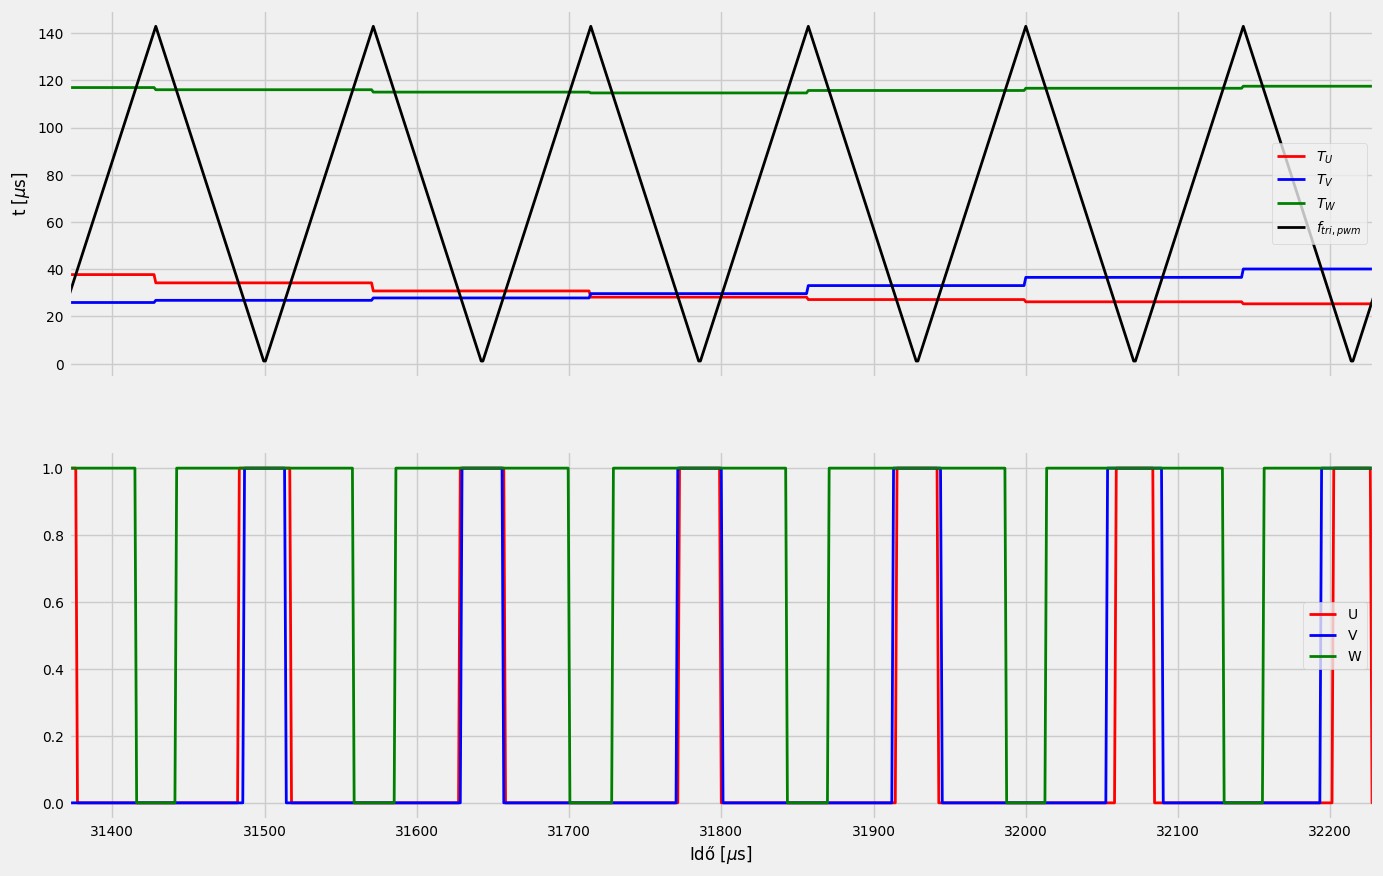

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cmath as cm
from numpy import pi

def ftri(x, p, a):
    return 4 * a / p * np.abs((x -p / 4) % p  - p/ 2) -a

f = 50
fs = 7e3
Vdc = 50
Vm = 20


UU = lambda x: Vm * np.sin(2 * np.pi * f * x + 0 * 2 * np.pi / 3)
UV = lambda x: Vm * np.sin(2 * np.pi * f * x + 1 * 2 * np.pi / 3)
UW = lambda x: Vm * np.sin(2 * np.pi * f * x + 2 * 2 * np.pi / 3)

# -----------------------------------------------------------------------------------------------

plt.style.use(['default', 'fivethirtyeight'])
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 10

systick = np.linspace(0, 40, 35001)*1e-3
dt = systick[1] - systick[0]
w = 2 * np.pi * f
Vrefmax = Vdc * np.sqrt(3) / 3
T = 1 / f
Ts = 1 / fs
print(f'Vdc: {Vdc:.4f} V')
print(f'Vref max: {Vrefmax:.4f} V')
print(f'sampling period: {Ts*1e6:.4f} us')
print(f'dt: {dt*1e6:.4f} us')
#if Vrefmax <= Vm: raise ValueError("Vm nagyobb, mint Vrefmax")
switchtable = np.array([[0,1,0,1,0,1,0,1], [0,0,1,1,0,0,1,1], [0,0,0,0,1,1,1,1]]).T
MClark = 2 / 3 * np.array([
    [1, -0.5, -0.5],
    [0, np.sqrt(3) / 2, -np.sqrt(3) / 2],
])
Ml2n = Vdc / 3 * np.array([
    [2, -1, -1],
    [-1, 2, -1],
    [-1, -1, 2]
])

Ml2l = Vdc * np.array([
    [1, -1, 0],
    [0, 1, -1],
    [-1, 0, 1]
])

MV = Ml2n.copy()

U = np.ones_like(systick)
V = np.ones_like(systick)
W = np.ones_like(systick)

U = np.zeros_like(systick)
V = np.zeros_like(systick)
W = np.zeros_like(systick)

Tsi = np.zeros((systick.shape[0], 3))
vtrii = np.zeros_like(systick)
s = 1

dc = np.zeros((systick.shape[0], 3))


dPeriod = int(np.ceil(Ts/dt))
cmpr=1
for i, ti in enumerate(systick):
    if i % dPeriod == 0:
        Vref = np.dot(MClark, np.array([UU(ti), UV(ti), UW(ti)]))
        theta = np.arctan2(Vref[1], Vref[0]) * 180 / np.pi
        if theta >= 0  and theta <= 60:
            s = 1
            swl = np.array([1, 1, 0])
            swr = np.array([1, 0, 0])
            Vl = np.dot(MClark, np.dot(MV, swl))
            Vr = np.dot(MClark, np.dot(MV, swr))
            
        elif theta >= 60  and theta <= 120:
            s = 2
            swl = np.array([0, 1, 0])
            swr = np.array([1, 1, 0])
            Vl = np.dot(MClark, np.dot(MV, swl))
            Vr = np.dot(MClark, np.dot(MV, swr))
            
        elif theta >= 120  and theta <= 180:
            s = 3
            swl = np.array([0, 1, 1])
            swr = np.array([0, 1, 0])
            Vl = np.dot(MClark, np.dot(MV, swl))
            Vr = np.dot(MClark, np.dot(MV, swr))
            
        elif theta <= -120  and theta >= -180:
            s = 4
            swl = np.array([0, 0, 1])
            swr = np.array([0, 1, 1])
            Vl = np.dot(MClark, np.dot(MV, swl))
            Vr = np.dot(MClark, np.dot(MV, swr))
            
        elif theta <= -60  and theta >= -120:
            s = 5
            swl = np.array([1, 0, 1])
            swr = np.array([0, 0, 1])
            Vl = np.dot(MClark, np.dot(MV, swl))
            Vr = np.dot(MClark, np.dot(MV, swr))
            
        elif theta <= 0  and theta >= -60:
            s = 6
            swl = np.array([1, 0, 0])
            swr = np.array([1, 0, 1])
            Vl = np.dot(MClark, np.dot(MV, swl))
            Vr = np.dot(MClark, np.dot(MV, swr))
    
        A = np.array([Vl, Vr]).T
        T = np.linalg.solve(A, Ts * Vref)
        Toff = Ts - T.sum()
        cmpr = (np.dot(np.array([swl, swr]).T, T) +  Toff / 2).ravel()
    

    dc[i] = cmpr / Ts
    vtri = Ts*(0.5 + 0.5 * ftri(ti+Ts/4, Ts, 1))
    Tsi[i] = cmpr
    vtrii[i] = vtri
    
    if cmpr[0] >= vtri:
        U[i] = 1.0
        
    if cmpr[1] >= vtri:
        V[i] = 1.0
        
    if cmpr[2] >= vtri:
        W[i] = 1.0
        
'''
np.savetxt("U.txt", np.array([systick, U*5]).T, fmt='%1.8f')
np.savetxt("V.txt", np.array([systick, V*5]).T, fmt='%1.8f')
np.savetxt("W.txt", np.array([systick, W*5]).T, fmt='%1.8f')

np.savetxt("U1.txt", np.array([systick, U * Vdc]).T, fmt='%1.8f')
np.savetxt("V1.txt", np.array([systick, V * Vdc]).T, fmt='%1.8f')
np.savetxt("W1.txt", np.array([systick, W * Vdc]).T, fmt='%1.8f')  
'''
systick = systick*1e6


t0 = 31.8
tspan = 6 * Ts
t0 = t0 * 1e3
tspan = tspan * 1e6
lm = [t0-tspan/2, t0+tspan/2]
'''
idx = np.logical_and(systick <= lm[1], systick >= lm[0])
Tsi = Tsi[idx]
vtrii = vtrii[idx]
U = U[idx]
V = V[idx]
W = W[idx]
systick = systick[idx]
'''

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex='all')
ax[0].plot(systick, Tsi[:, 0]*1e6, 'r-', label=r'$T_{U}$')
ax[0].plot(systick, Tsi[:, 1]*1e6, 'b-', label=r'$T_{V}$')
ax[0].plot(systick, Tsi[:, 2]*1e6, 'g-', label=r'$T_{W}$')
ax[0].plot(systick, vtrii*1e6, 'k-', label=r'$f_{tri,pwm}$')

ax[0].set_ylabel(r"t [$\mu$s]")

ax[1].plot(systick, U, 'r-', label='U')
ax[1].plot(systick, V, 'b-', label='V')
ax[1].plot(systick, W, 'g-', label='W')

ax[0].legend(loc='right')
ax[1].legend()
ax[0].set_xlim(lm);
ax[1].set_xlim(lm);
plt.xlabel(r'Idő [$\mu$s]')
#plt.savefig("media/svpwm.png", dpi=300, bbox_inches='tight')


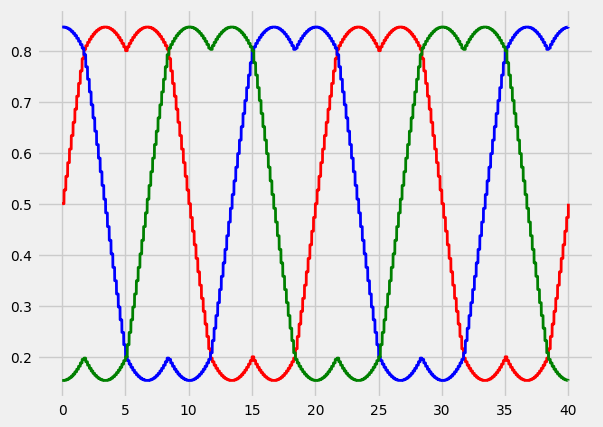

In [41]:
a,b,c = Tsi.T/Ts #* Vdc

'''
plt.plot(systick, a-b)
plt.plot(systick, a-c)
plt.plot(systick, b-c)
'''

plt.plot(systick/1e3, a, 'r');
plt.plot(systick/1e3, b, 'b');
plt.plot(systick/1e3, c, 'g');

In [3]:
sq3 = np.sqrt(3)
sq2 = np.sqrt(2)
Vm/sq2

14.14213562373095

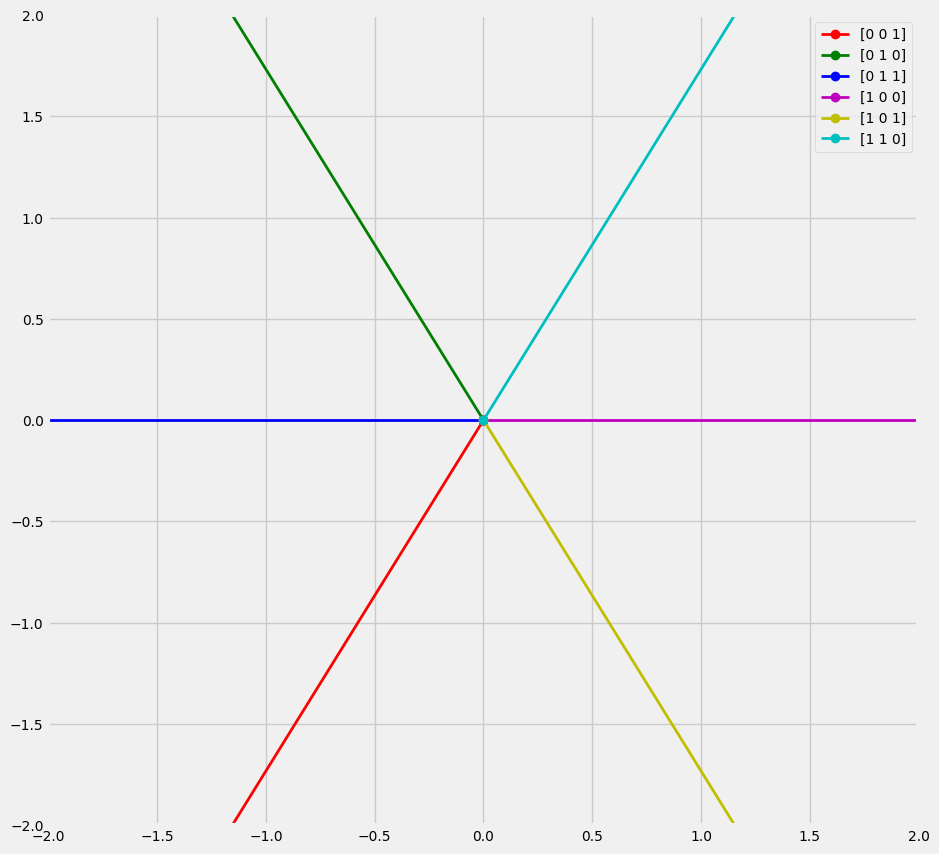

In [4]:
Vdc = 50
swt = np.array([[0,0,0,0,1,1,1,1], [0,0,1,1,0,0,1,1],[0,1,0,1,0,1,0,1]]).T
Ml2n = Vdc / 3 * np.array([
    [2, -1, -1],
    [-1, 2, -1],
    [-1, -1, 2]
])

Ml2l = Vdc * np.array([
    [1, -1, 0],
    [0, 1, -1],
    [-1, 0, 1]
])


plt.figure(figsize=(10, 10))
cs = ['r', 'g', 'b', 'm', 'y', 'c']
for i in range(1, 7):
    Vabc = np.dot(Ml2n, swt[i])
    Vi = np.dot(MClark, Vabc)
    plt.plot([0, Vi[0]], [0, Vi[1]], c=cs[i-1], marker='o', label=f'{swt[i]}')
    
    
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.legend();

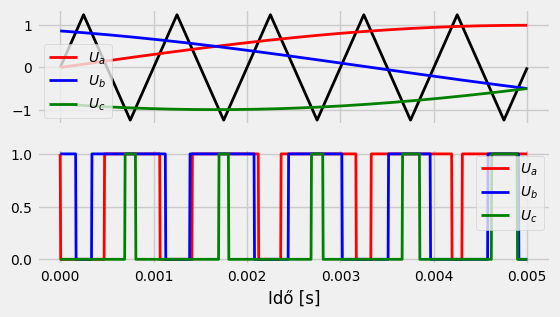

In [5]:


t = np.linspace(0, 5e-3, 1001)
a = np.sin(2*pi*f*t)
b = np.sin(2*pi*f*t + 2*pi/3)
c = np.sin(2*pi*f*t+ 4*pi/3)
vtri = ftri(t, 1/1000, 1 / .8)

ua = np.zeros_like(t)
ub = np.zeros_like(t)
uc = np.zeros_like(t)

idx = vtri <= a
ua[idx] = 1

idx = vtri <= b
ub[idx] = 1

idx = vtri <= c
uc[idx] = 1


fig, ax = plt.subplots(2, 1, figsize=(150*0.039370, 80*0.039370), sharex='all')
ax[0].plot(t, vtri, 'k-')

ax[0].plot(t, a, 'r-', label=r'$U_a$')
ax[0].plot(t, b, 'b-', label=r'$U_b$')
ax[0].plot(t, c, 'g-', label=r'$U_c$');
ax[0].legend();

ax[1].plot(t, ua, 'r-', label=r'$U_a$')
ax[1].plot(t, ub, 'b-', label=r'$U_b$')
ax[1].plot(t, uc, 'g-', label=r'$U_c$');
ax[1].legend();

plt.xlabel("Idő [s]");
plt.savefig("media/spwm.png", dpi=300, bbox_inches='tight')